In [54]:
import pandas as pd
import numpy as np
import math

In [77]:
!pip install sklearn-ts==0.0.4

ERROR: Could not find a version that satisfies the requirement sklearn-ts==0.0.5 (from versions: 0.0.1, 0.0.2, 0.0.3, 0.0.4)
ERROR: No matching distribution found for sklearn-ts==0.0.5


Load data

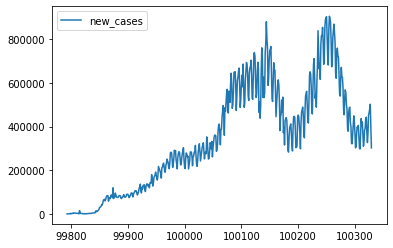

In [56]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
#covid.head(2)

target = 'new_cases'
h = 14

dataset = covid[(covid['location']=='World')].copy()[[target, 'date']]
dataset[[target]].plot()

In [57]:
# prepare features
features = ['year', 'month', f'{h}_lag', f'{h}_lag_rolling', 'dayofweek', 'intercept', 'trend', 'log']
categorical_features = ['year', 'month', 'dayofweek']
numerical_features = [f'{h}_lag', f'{h}_lag_rolling', 'intercept', 'trend', 'log']

dataset['date'] = pd.to_datetime(dataset['date'])
dataset.index = dataset['date']
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year
dataset['dayofweek'] = dataset['date'].dt.dayofweek
dataset[f'{h}_lag'] = dataset[target].shift(h)
dataset[f'rolling_{target}'] = dataset[target].rolling(window=h).mean()
dataset[f'{h}_lag_rolling'] = dataset[f'rolling_{target}'].shift(h)
dataset['intercept'] = 1
dataset['trend'] = range(dataset.shape[0])
dataset['log'] = dataset['trend'].apply(lambda x: math.log(x+1))
dataset = dataset[['date', target] + numerical_features +categorical_features]
dataset = dataset.dropna()

In [58]:
from sklearn_ts.validator import check_model

In [59]:
! pip install prophet
from prophet import Prophet

In [61]:
df = dataset.copy()
df['ds'] = df['date']
df['y'] = df[target]
m = Prophet(growth='linear', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.add_regressor(f'{h}_lag_rolling')
m.fit(df)

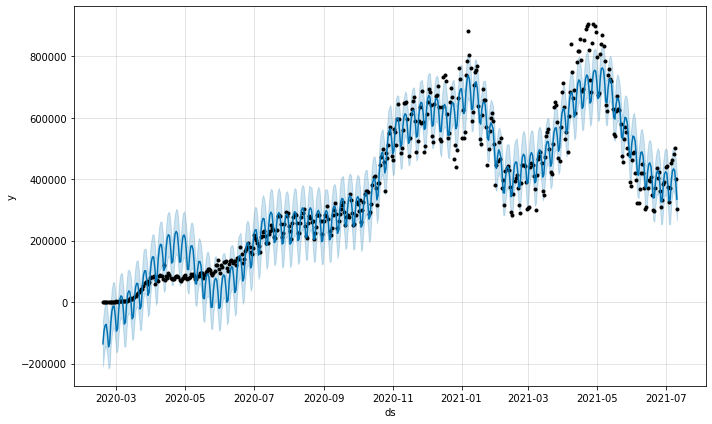

In [62]:
#future = m.make_future_dataframe(periods=14)
forecast = m.predict(df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

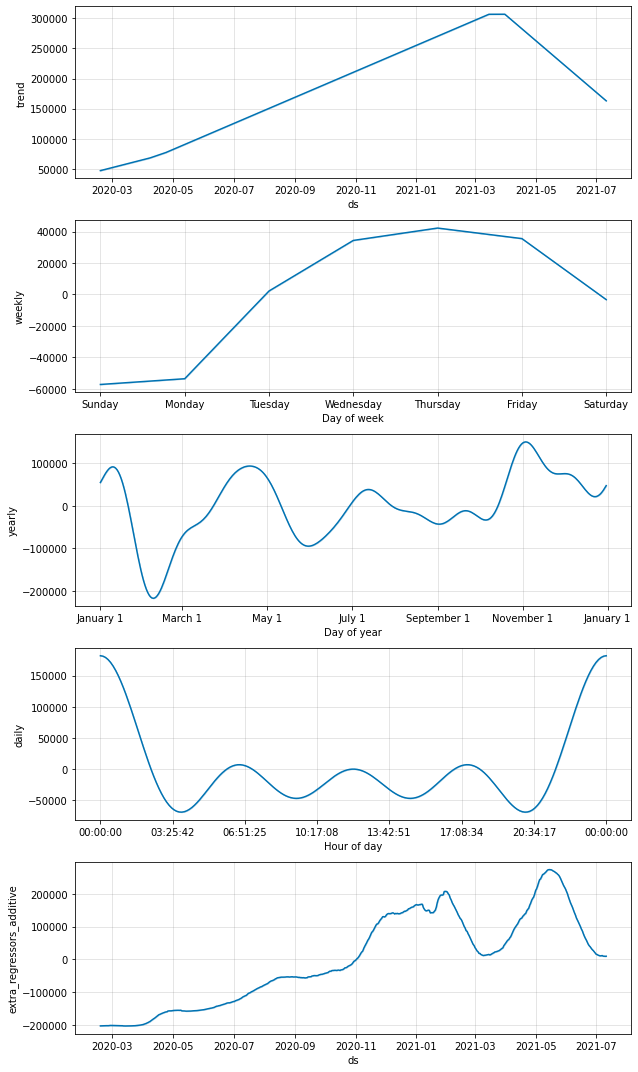

In [17]:
fig = m.plot_components(forecast)

In [82]:

regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,14_lag_rolling,additive,349442.503081,0.581761,0.581761,0.581761


In [87]:
from sklearn.base import BaseEstimator, RegressorMixin
from prophet.utilities import regressor_coefficients


class ProphetRegressor(BaseEstimator, RegressorMixin):
    # https://facebook.github.io/prophet/docs/quick_start.html#python-api

    def __init__(self, target='new_cases', features=['date', f'{h}_lag_rolling'], regressors=[f'{h}_lag_rolling']):
        self.target = target
        self.features = features
        self.regressors = regressors

        self.model = None
        self.predictions= None

    def fit(self, X, y):
        df = pd.DataFrame(X, columns=self.features)

        df['ds'] = df['date']
        df['y'] = y.values

        m = Prophet(growth='linear', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
        for regressor in self.regressors:
            m.add_regressor(regressor)
        m.fit(df)

        self.model = m
        self.feature_importances_ = [None] + regressor_coefficients(m)['coef'].tolist()  # place for date
        return self

    def predict(self, X):
        df = pd.DataFrame(X, columns=self.features)
        df['ds'] = df['date']
        predictions = self.model.predict(df)
        self.predictions = predictions[['ds', 'yhat_lower', 'yhat_upper']].rename(columns={'yhat_lower': 'pi_lower', 'yhat_upper': 'pi_upper'})
        return predictions['yhat'].values

    def get_params(self, deep=True):
        return {"target": self.target, 'regressors': self.regressors, 'features': self.features}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Grid search
[None, 0.43669456762673353]
[None, 0.08074580809214332]
[None, 0.09895108815108966]
[None, 0.49399333971034887]
[None, 0.5375522428117859]
[None, 0.5479055379785187]
[None, 0.43669456762673353]
[None, 0.08074580809214332]
[None, 0.09895108815108966]
[None, 0.49399333971034887]
[None, 0.5375522428117859]
Fitting to train
[None, 0.5479055379785187]
Plot


{'regressor__regressors': ['14_lag_rolling']}

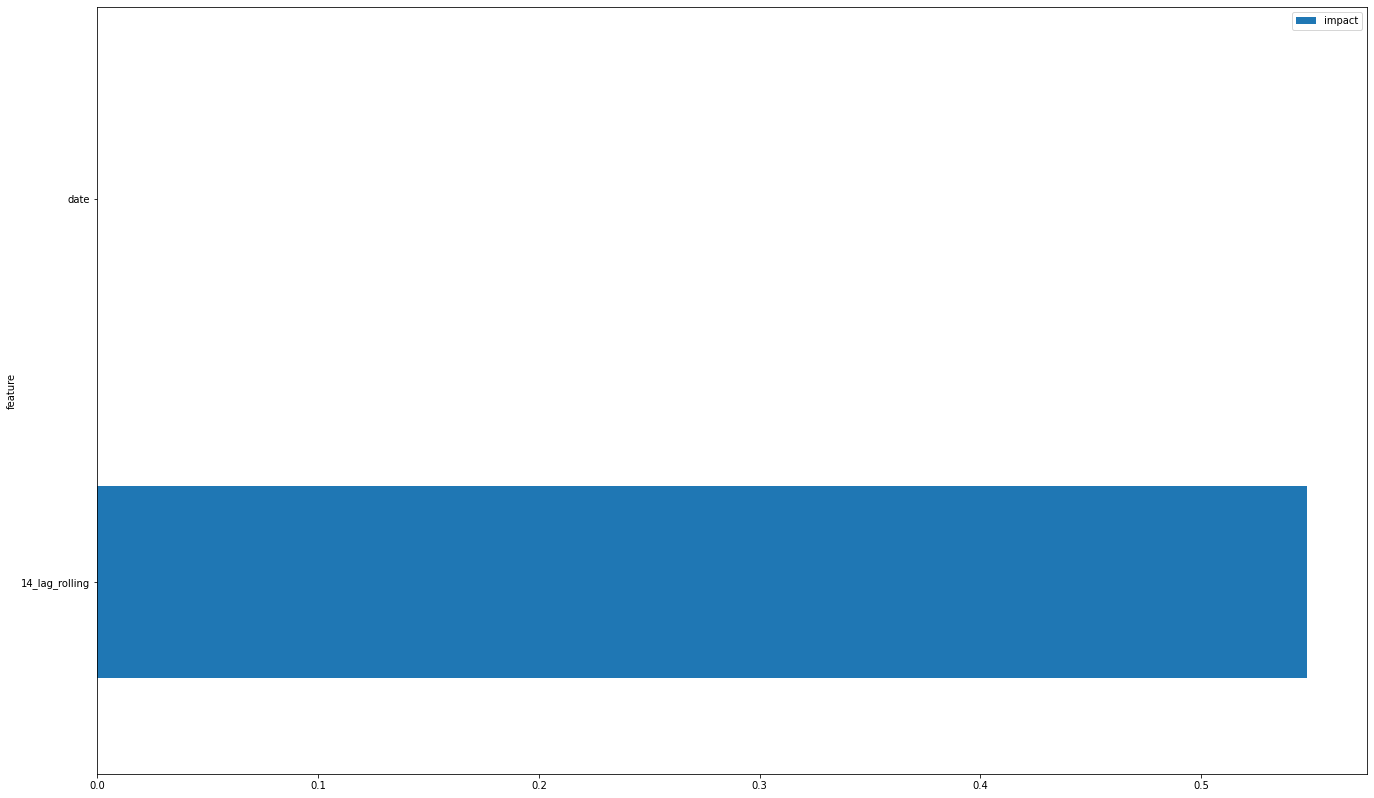

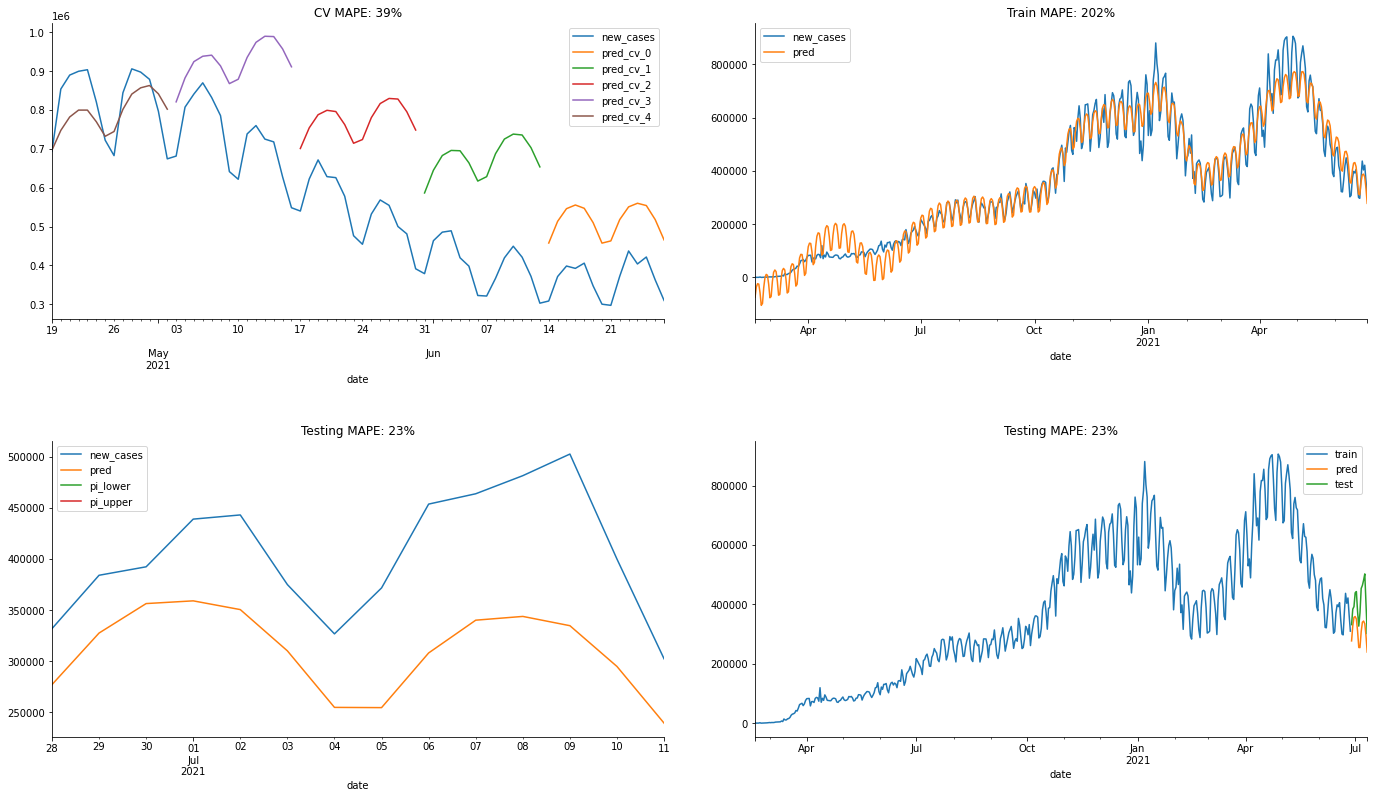

In [88]:
params = {'regressors': [[f'{h}_lag_rolling']]}
regressor = ProphetRegressor()

results = check_model(regressor, params, dataset, features=['date', f'{h}_lag_rolling'])
results['best_params']